In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

Plots.PyPlotBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "4uet"
# Leo modos
modes_4uet, evals_4uet = JUMD.readPtrajModes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4uet))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_4uet = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4uet = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4uet = (ndd_out_4uet .- vol_avg_4uet) .* evals_4uet
vgv_4uet = vgv_4uet ./ norm(vgv_4uet);

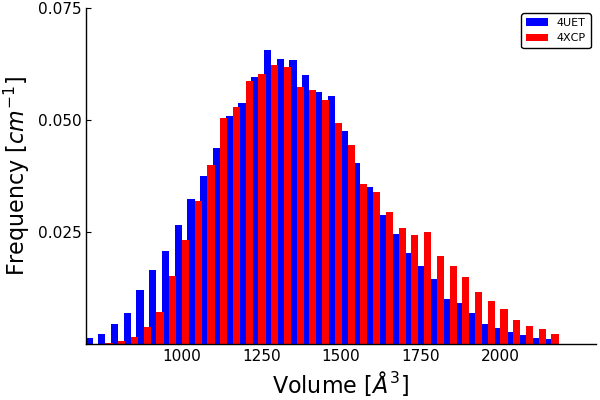

In [17]:
using StatPlots
trj_vol_4xcp = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, "4xcp", "cavidad", string("vol_trj_4xcp")))[:, 3]);
st = 40
bin_vol = collect(700:st:2200)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4uet, Whis_vol_4uet = JUMD.weightedHist(trj_vol, bin_vol, wgh_vol, true, false);
Wbins_vol_4xcp, Whis_vol_4xcp = JUMD.weightedHist(trj_vol_4xcp, bin_vol, wgh_vol, true, false);

grp = repeat(["4UET", "4XCP"], inner = length(Wbins_vol_4xcp))
clr = repeat([colorant"#0000FF", colorant"#FF0000"],
    inner = length(Wbins_vol_4xcp))

ambas_uet_xcp = groupedbar(
    repeat(Wbins_vol_4uet, outer = 2), hcat(Whis_vol_4uet, Whis_vol_4xcp),
    group = grp, fillcolor = clr, bar_width = 45,
    xticks = 1E3:250:2E3, yticks = .025:.025:.75,
    xlims = (700, 2300), ylims = (0, .075),
    
    linecolor = false, legend = (.9, .95),
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ")

In [18]:
savefig(ambas_uet_xcp, joinpath(rtdos, "papel", "1", string("ambas_uet_xcp.svg")))

## Volumen de la trayectoria

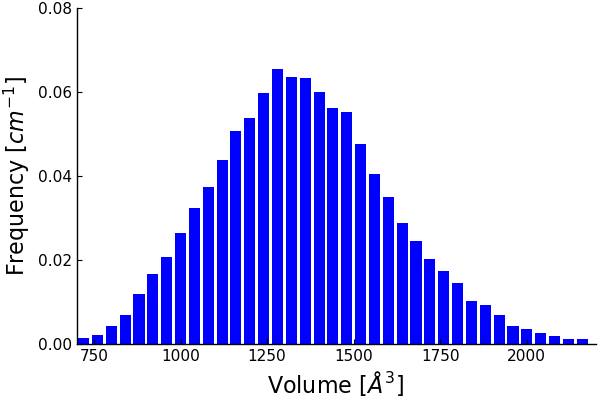

In [8]:
st = 40
bin_vol = collect(700:st:2200)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4uet, Whis_vol_4uet = JUMD.weightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_4uet, Whis_vol_4uet,
    xlims = (700, 2200), ylims = (0, .08),
    xticks = 500:250:2000,
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ",
    linecolor = false, fillcolor = Colors.colorant"#0000FF",
    legend = false)

In [4]:
savefig(plt_his_vol, joinpath(rtdos, "papel", "1", string("1_vol_", pdb, ".svg")))

In [5]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1352.5429568999998
  254.2512729885925

## Energía

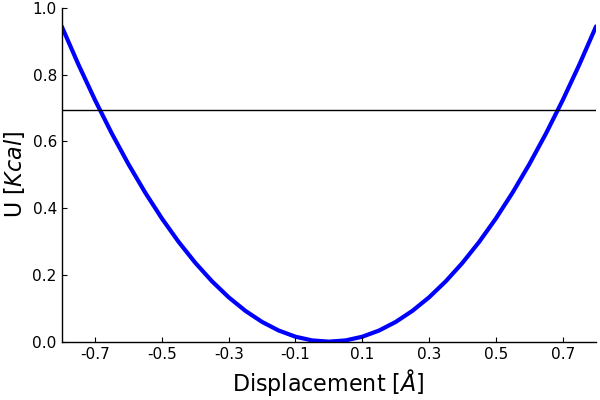

In [6]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_4uet = Array{Float64,1}(undef, npasos)
i = 0
for d in pasos
    i+=1
    E_4uet[i] = JUMD.energiaGdte(evals_4uet, vgv_4uet, d)
end

plt_u = plot(pasos, E_4uet,
    xticks = -.7:.2:.7, yticks = 0:.2:1.,   
    xlims = (-.8, .8), ylims = (0, 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = L"U $[Kcal]$", xaxis = L"Displacement $[\AA]$ ",
    linecolor = Colors.colorant"#0000FF", linewidth = 3,
    legend = false, grid = false)
hline!([RT], linecolor = Colors.colorant"black")

In [7]:
savefig(plt_u, joinpath(rtdos, "papel", "7", string("7_U_", pdb, ".svg")))

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

In [17]:
function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(undef, aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(10:144))

fid = h5open(joinpath(rtdos, string("diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

1
2
3
4
5
6
7
8
9
10


#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [18]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_4uet = Array{Float64, 1}(undef, nframes)
prj_2_4uet = Array{Float64, 1}(undef, nframes)
prj_3_4uet = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4uet[i] = dot(norm_dif[:, i], modes_4uet[:, 1])
    prj_2_4uet[i] = dot(norm_dif[:, i], modes_4uet[:, 2])
    prj_3_4uet[i] = dot(norm_dif[:, i], modes_4uet[:, 3])
end

# Smooth
smooth_prj_1_4uet = [ mean(prj_1_4uet[i:i+9]) for i = 1:10:length(prj_1_4uet)-9 ]
smooth_prj_2_4uet = [ mean(prj_2_4uet[i:i+9]) for i = 1:10:length(prj_2_4uet)-9 ]
smooth_prj_3_4uet = [ mean(prj_3_4uet[i:i+9]) for i = 1:10:length(prj_3_4uet)-9 ];

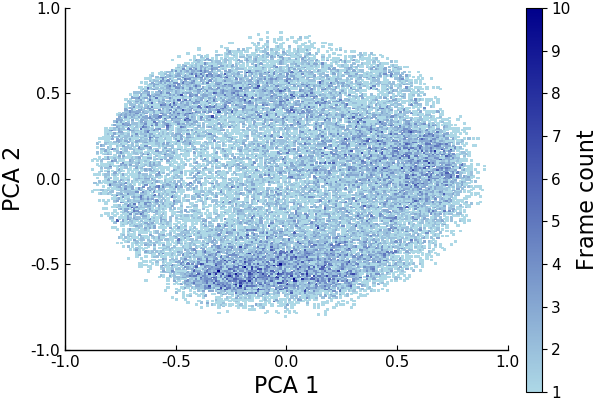

In [19]:
plt_2his = histogram2d(smooth_prj_1_4uet, smooth_prj_2_4uet, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    nbins = 200, seriescolor = :blues, grid = false)

In [20]:
savefig(plt_2his, joinpath(rtdos, "papel", "2", string("2_PCAHis_", pdb, ".svg")))

In [23]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframes
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos));

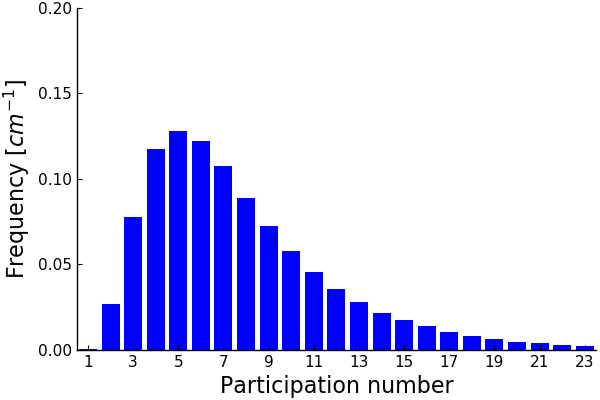

In [24]:
bin_vol = collect(1:1:25)
wgh_vol = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.WeightedHist(marcos_pnu, bin_vol, wgh_vol, true, false);

plt_his_pn = bar(bins_marcos_pnu .- .5 , his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#0000FF", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Participation number",
    legend = false, grid = false)

In [25]:
savefig(plt_his_pn, joinpath(rtdos, "papel",  "2", string("2_HisPn_", pdb, ".svg")))

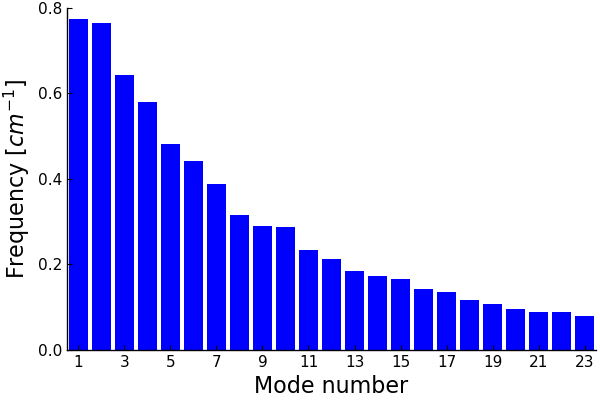

In [26]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.WeightedHist(flat_marcos_modos,
    bin_mod, wgh_mod, false, false);

plt_freq_pn = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.2:.8,    
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#0000FF", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Mode number",
    legend = false, grid = false)

In [27]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_ModPn_", pdb, ".svg")))